# [문자-단위 RNN으로 이름 분류](https://tutorials.pytorch.kr/intermediate/char_rnn_classification_tutorial.html)

18개 언어로 된 수천 개의 성을 훈련시키고, 철자에 따라 이름이 어떤 언어인지 예측합니다.  

```
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish
```

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

# 텍스트 표현
> 신경망으로 자연어 처리(NLP) 작업을 해결하려면 텍스트를 텐서로 표현하는 방법이 필요합니다. 컴퓨터는 이미 텍스트 문자를 ASCII(아스키 코드) 또는 UTF-8과 같은 인코딩을 사용하여 화면의 글꼴에 메핑되는 숫자로 나타내고 있습니다.

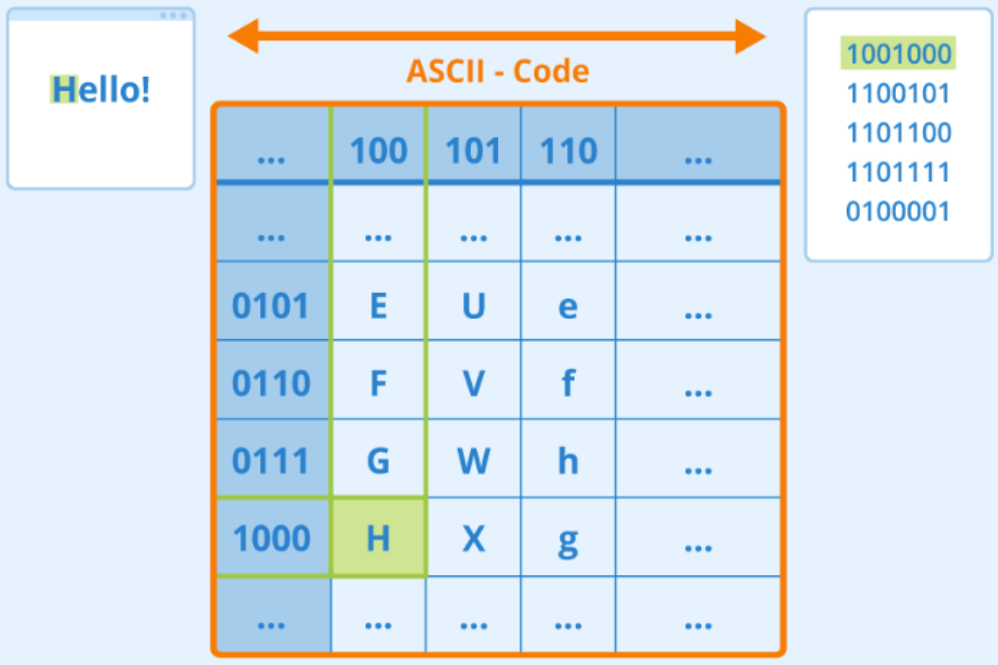

## 비트와 바이트

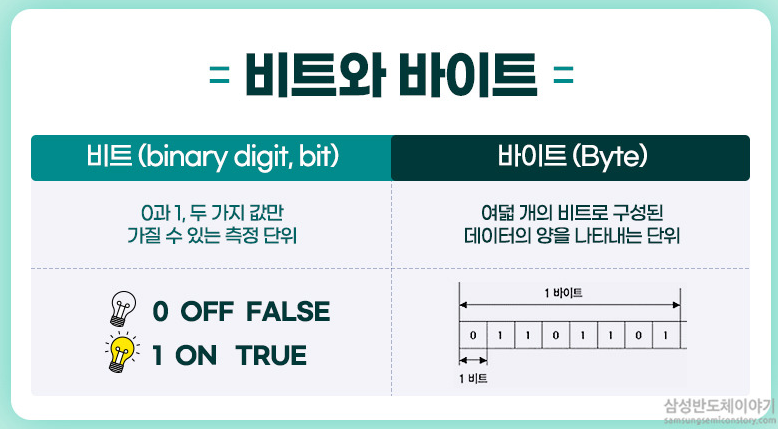

## 인코딩과 디코딩

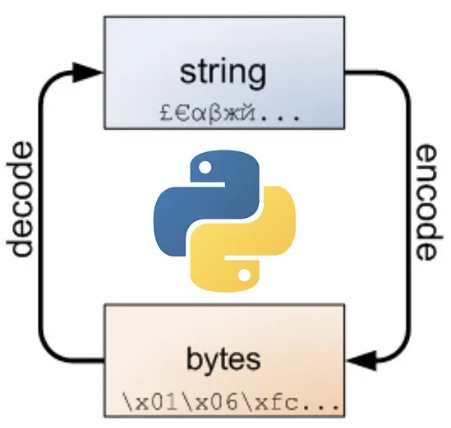

### 인코딩   
> 문자열을 바이트코드로 변환

파이썬에서 문자열은 유니코드로 처리합니다. 따라서 인코딩한다는 의미는 유니코드를 `utf-8`, `euc-kr`, `ascii` 형식의 `byte 코드`로 변환하는 것을 의미합니다. 

In [2]:
str = '한글'

encoded = str.encode('utf-8')
encoded

b'\xed\x95\x9c\xea\xb8\x80'

In [3]:
encoded = str.encode('euc-kr')
encoded

b'\xc7\xd1\xb1\xdb'

### 디코딩    
> 바이트 코드를 문자열로 변환

파이썬에서 디코딩한다는 것은 byte 코드를 유니코드로 변환한다는 것을 뜻합니다. 

In [4]:
str = b'\xc7\xd1\xb1\xdb'

decoded = str.decode('euc-kr')
decoded

'한글'

## 유니코드 정규화(Unicode Normalization)

### [ASCII(아스키 코드)](https://namu.wiki/w/%EC%95%84%EC%8A%A4%ED%82%A4%20%EC%BD%94%EB%93%9C?from=ASCII) 

- 가장 처음 만들어진 인코딩이 ASCII 코드이다.
- 128개의 문자조합을 제공하는 7비트(1비트는 통신 에러 검출용) 부호
- 알파벳, 숫자, 특수기호 그외 컴퓨터에 필요한 몇 가지만이 정의되어 있어서 점차 여러 나라에서 컴퓨터를 사용하게 되고 통신이 발달하다보니 기존의 아스키 인코딩보다 더 많은 문자들을 정의한 새로운 인코딩이 필요해짐  

### [Unicode(유니 코드)](https://namu.wiki/w/%EC%9C%A0%EB%8B%88%EC%BD%94%EB%93%9C)

- 각 나라별 언어를 모두 표현하기 위해 나온 코드 체계가 유니코드  
- 사용중인 운영체제, 프로그램, 언어에 관계 없이 문자마다 고유한 코드 값을 제공하는 새로운 개념의 코드  
- UTF-8 (가변길이 인코딩):   
utf-8은 가장 많이 사용되는 가변 길이 유니코드 인코딩이다.

- `ord()`를 통해 문자를 아스키 코드로 변환할 수 있다.

In [5]:
ord('한')

54620

- `chr()`를 통해 아스키 코드를 문자로 변환할 수 있다.

In [6]:
chr(54620)

'한'

### unicodedata

파이썬으로 텍스트 전처리를 하다가 정규식으로 한글 영어만 추출할 때, 가끔 데이터가 None이 되는 경우가 많이 발생한다.   
그런 경우에는 대부분 같은 문자이지만 `아스키 코드가 달라서` 발생하는 문제들이다.   

이런 이슈(오류)들을 피하기 위해서 유니코드 정규화를 해야 한다.

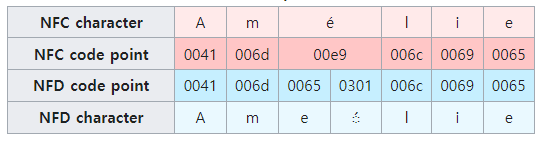

In [7]:
import unicodedata

- NFC(Normal From Composed):   
구성된 문자 반환

In [8]:
unicodedata.normalize('NFC', 'Hello')

'Hello'

- NFD(Normal Form Decomposed):   
분해, 결합된 문자 제공

In [9]:
unicodedata.normalize('NFD', 'Hello')

'Hello'

`unicodedata.category(chr)`:   
> chr 문자에 할당된 일반 범주(general category)를 문자열로 반환합니다.
> - `Mn`: Mark, no spacing(발음구별기호)
> - `LI`: Letter, lower case 
> - `Lu`: Letter, upper case

In [10]:
unicodedata.category('c')

'Ll'

In [11]:
unicodedata.category('C')

'Lu'

# 1.데이터 준비
> [데이터 다운로드](https://download.pytorch.org/tutorial/data.zip)

데이터는 [Language].txt 라는 18개의 텍스트 파일로 구성되어 있습니다. 각 파일에는 한 줄에 하나의 이름이 포함되어 있으며, 대부분 로마자로 되어 있습니다.

In [12]:
string.ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [13]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'  # Mn은 Mark, no spacing 를 뜻함.
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [14]:
print(f'all_letters: {all_letters}')
print(f'n_letters: {n_letters}')

all_letters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
n_letters: 57


In [15]:
# 구글 드라이브 연결(데이터 로드를 위해서)
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [16]:
DATA_PATH = "/content/data/MyDrive/lecture/6. deep learning/7-3. NLP_Pytorch/data/"

In [17]:
for filename in glob.glob(DATA_PATH+'names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    print(f'category: {category}')

category: German
category: Spanish
category: Greek
category: Chinese
category: Portuguese
category: Scottish
category: Korean
category: Vietnamese
category: English
category: Russian
category: French
category: Polish
category: Arabic
category: Irish
category: Dutch
category: Japanese
category: Czech
category: Italian


In [18]:
# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [19]:
print(f'filename: {filename}')
lines = readLines(filename)
print(f'lines: {lines}')

filename: /content/data/MyDrive/lecture/6. deep learning/7-3. NLP_Pytorch/data/names/Italian.txt
lines: ['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni', 'Abatescianni', 'Abba', 'Abbadelli', 'Abbascia', 'Abbatangelo', 'Abbatantuono', 'Abbate', 'Abbatelli', 'Abbaticchio', 'Abbiati', 'Abbracciabene', 'Abbracciabeni', 'Abelli', 'Abello', 'Abrami', 'Abramo', 'Acardi', 'Accardi', 'Accardo', 'Acciai', 'Acciaio', 'Acciaioli', 'Acconci', 'Acconcio', 'Accorsi', 'Accorso', 'Accosi', 'Accursio', 'Acerbi', 'Acone', 'Aconi', 'Acqua', 'Acquafredda', 'Acquarone', 'Acquati', 'Adalardi', 'Adami', 'Adamo', 'Adamoli', 'Addario', 'Adelardi', 'Adessi', 'Adimari', 'Adriatico', 'Affini', 'Africani', 'Africano', 'Agani', 'Aggi', 'Aggio', 'Agli', 'Agnelli', 'Agnellutti', 'Agnusdei', 'Agosti', 'Agostini', 'Agresta', 'Agrioli', 'Aiello', 'Aiolfi', 'Airaldi', 'Airo', 'Aita', 'Ajello', 'Alagona', 'Alamanni', 'Albanesi', 'Albani', 'Albano', 'Alberghi', 'Alberghini', 'Alberici', 'Alberighi', 'Alb

In [20]:
# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

for filename in glob.glob(DATA_PATH+'names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(category_lines['Korean'][:5])

['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']


In [21]:
category_lines.keys()

dict_keys(['German', 'Spanish', 'Greek', 'Chinese', 'Portuguese', 'Scottish', 'Korean', 'Vietnamese', 'English', 'Russian', 'French', 'Polish', 'Arabic', 'Irish', 'Dutch', 'Japanese', 'Czech', 'Italian'])

In [22]:
all_categories

['German',
 'Spanish',
 'Greek',
 'Chinese',
 'Portuguese',
 'Scottish',
 'Korean',
 'Vietnamese',
 'English',
 'Russian',
 'French',
 'Polish',
 'Arabic',
 'Irish',
 'Dutch',
 'Japanese',
 'Czech',
 'Italian']

## 이름을 Tensor로 변경
> One-Hot vector를 사용하여 Tensor로 변경

In [23]:
'''
.. NOTE::
역자 주:  One-Hot 벡터는 언어를 다룰 때 자주 이용되며,
단어, 글자 등을 벡터로 표현할 때 단어, 글자 사이의 상관 관계를 미리 알 수 없을 경우,
One-Hot으로 표현하여 서로 직교한다고 가정하고 학습을 시작합니다.
이와 동일하게, 상관 관계를 알 수 없는 다른 데이터의 경우에도 One-Hot 벡터를 활용할 수 있습니다.
'''

import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0, b = 1
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한 개의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(all_letters)
print('-'*50)
print(letterToTensor('e'))
print('-'*50)
print(lineToTensor('Jones').shape) # print(lineToTensor('Jones').size())

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
--------------------------------------------------
tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
--------------------------------------------------
torch.Size([5, 1, 57])


# 2.네트워크 생성

## [RNN(Recurrent Neural Networks)](https://ko.wikipedia.org/wiki/%EC%88%9C%ED%99%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D)
- RNN이란 Recurrent Neural Networks의 약자로, 순환 신경망을 뜻합니다. 순환 신경망이라는 이름은 입력받는 신호의 길이가 한정되지 않은 동적 데이터를 처리한다는 점에서 붙여진 이름입니다.    

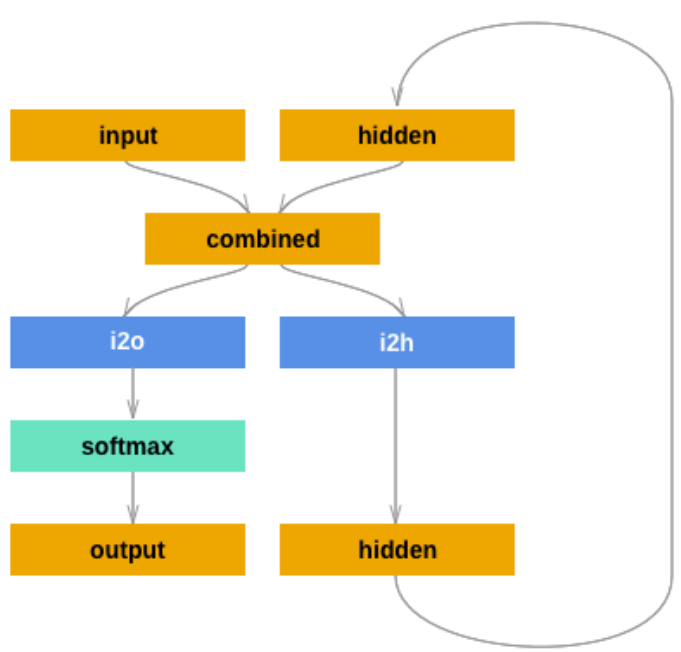

- RNN은 입력과 출력을 시퀀스 단위로 처리합니다.(시퀀스란 문장 같은 단어가 나열된 것을 뜻합니다.)   

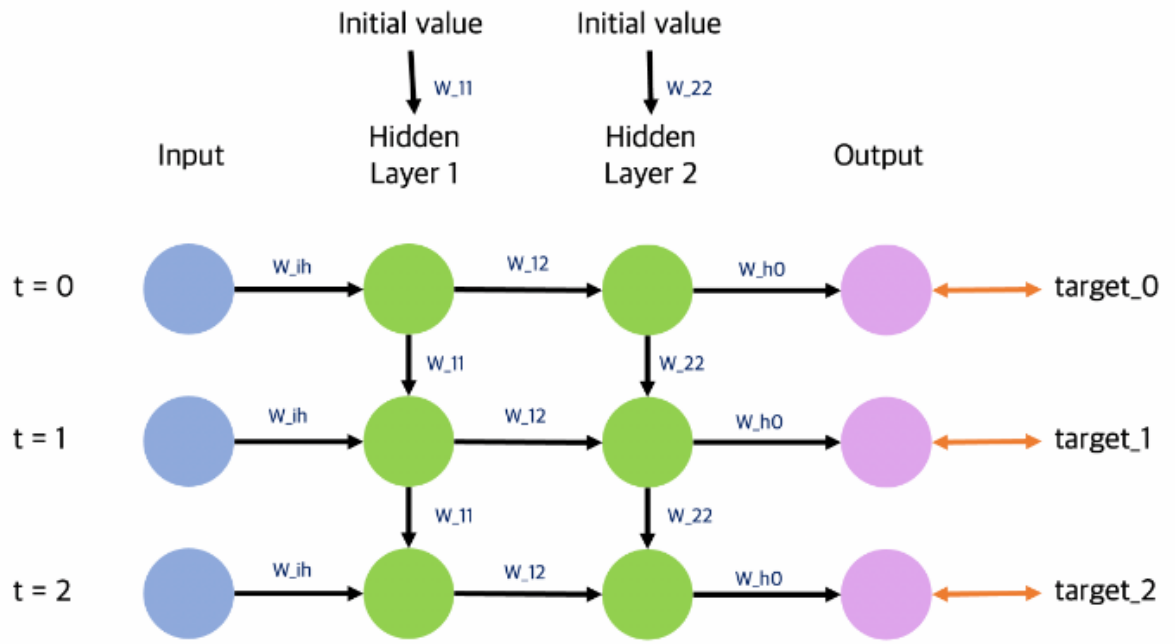

In [24]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [25]:
print(f'n_letters: {n_letters} / n_categories: {n_categories}')

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
rnn

n_letters: 57 / n_categories: 18


RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [42]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
import torchinfo

In [49]:
# input.shape: [batch size, letters size] -> (32, 57)
# hidden.shape: [batch size, hidden size] -> (32, 128)
# (sinput, hidden) -> ((32, 57), (32, 128))
torchinfo.summary(rnn, ((32, 57), (32, 128))) 

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [32, 18]                  --
├─Linear: 1-1                            [32, 128]                 23,808
├─Linear: 1-2                            [32, 18]                  3,348
├─LogSoftmax: 1-3                        [32, 18]                  --
Total params: 27,156
Trainable params: 27,156
Non-trainable params: 0
Total mult-adds (M): 0.87
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 0.11
Estimated Total Size (MB): 0.17

이 네트워크의 한 단계를 실행하려면 입력(현재 문자 Tensor)과 이전의 은닉 상태(처음에는 0으로 초기화)를 전달해야 합니다.    
출력(각 언어의 확률)과 다음 은닉 상태(다음 단계를 위해 유지)를 돌려받습니다.

In [44]:
input = letterToTensor('A') # 입력
hidden = rnn.initHidden() # 처음에는 0으로 초기화

output, next_hidden = rnn(input, hidden)

In [27]:
print(f'{next_hidden.shape}')
next_hidden

torch.Size([1, 128])


tensor([[ 0.0249,  0.1275, -0.0930,  0.0530, -0.0034, -0.0468,  0.0649,  0.0599,
          0.0734, -0.0272,  0.0283,  0.0994,  0.0673,  0.0267,  0.0122,  0.0154,
          0.0094,  0.0448,  0.0048, -0.0535,  0.1151, -0.0129,  0.0596,  0.0431,
          0.0242, -0.0320, -0.0161, -0.0037, -0.0027,  0.0744, -0.0371,  0.0238,
          0.0588,  0.0061, -0.0872,  0.0241, -0.0364, -0.0012, -0.0746, -0.0026,
          0.0994, -0.1298,  0.0582,  0.1100,  0.0937, -0.0533, -0.0020,  0.0796,
          0.0846, -0.0922, -0.0171, -0.0247,  0.0561, -0.0763, -0.0221,  0.0200,
         -0.0564,  0.0595, -0.0084, -0.0654, -0.0758,  0.0323,  0.0719,  0.0486,
         -0.0455,  0.0122, -0.0186, -0.0980,  0.0338, -0.0450, -0.0132, -0.0013,
          0.0377,  0.0256,  0.0393, -0.1072,  0.1196,  0.0891, -0.0533, -0.0237,
         -0.0592,  0.0516,  0.0120, -0.0713,  0.0017, -0.1006,  0.1042,  0.0948,
          0.0341, -0.0639,  0.1036, -0.0318, -0.0126,  0.0229, -0.0120, -0.0013,
          0.0633, -0.0034,  

In [28]:
print(f'{output.shape}')
output

torch.Size([1, 18])


tensor([[-2.9266, -2.8503, -2.8493, -2.8744, -2.7924, -2.9469, -2.9610, -2.8463,
         -2.8685, -2.9721, -2.9201, -2.9000, -2.7958, -2.8652, -2.9000, -3.0221,
         -2.8051, -2.9668]], grad_fn=<LogSoftmaxBackward0>)

In [29]:
top_n, top_i = output.topk(1) # topk(n) 텐서의 가장 큰 n번째 값 및 주소

top_n, top_i

(tensor([[-2.7924]], grad_fn=<TopkBackward0>), tensor([[4]]))

In [30]:
category_i = top_i[0].item()   # 텐서에서 정수 값으로 변경

category_i, all_categories[category_i]

(4, 'Portuguese')

# 3.학습

## 학습 준비
학습결과인 `output`을 해석할 수 있는 함수 생성

In [31]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)  # topk(n) 텐서의 가장 큰 n번째 값 및 주소
    category_i = top_i[0].item()   # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

In [32]:
print(categoryFromOutput(output))

('Portuguese', 4)


In [33]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(5):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(f'category = {category} / line = {line}')
    print(f'category_tensor = {category_tensor.shape} / line_tensor = {line_tensor.shape}')
    print('-'*70)

category = Czech / line = Hrula
category_tensor = torch.Size([1]) / line_tensor = torch.Size([5, 1, 57])
----------------------------------------------------------------------
category = Dutch / line = Koole
category_tensor = torch.Size([1]) / line_tensor = torch.Size([5, 1, 57])
----------------------------------------------------------------------
category = German / line = Lewerentz
category_tensor = torch.Size([1]) / line_tensor = torch.Size([9, 1, 57])
----------------------------------------------------------------------
category = Japanese / line = Miyazawa
category_tensor = torch.Size([1]) / line_tensor = torch.Size([8, 1, 57])
----------------------------------------------------------------------
category = Spanish / line = Rosales
category_tensor = torch.Size([1]) / line_tensor = torch.Size([7, 1, 57])
----------------------------------------------------------------------


## 네트워크 학습

학습 루프
1. 입력과 목표 Tensor 생성
2. 0으로 초기화 된 은닉 상태 생성
3. 각 문자 읽기
4. 다음 준자를 위한 은닉 상태 유지
5. 목표와 최종 출력 비교 
6. 역전파
7. 출력과 손실 반환 

In [34]:
criterion = nn.NLLLoss() # 손실함수

In [35]:
learning_rate = 0.005  # 학습률을 너무 높게 설정하면 발산할 수 있고, 너무 낮으면 학습이 되지 않을 수 있습니다.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [36]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.6794 To / Italian ✗ (Vietnamese)
10000 10% (0m 13s) 2.4765 Schrijnemakers / Greek ✗ (Dutch)
15000 15% (0m 20s) 2.7451 Jordan / Irish ✗ (English)
20000 20% (0m 26s) 0.3088 Kotsiopoulos / Greek ✓
25000 25% (0m 33s) 1.5157 West / German ✓
30000 30% (0m 39s) 2.1739 Bavidoff / Italian ✗ (Russian)
35000 35% (0m 48s) 1.2169 D'cruz / Spanish ✗ (Portuguese)
40000 40% (0m 54s) 2.4061 Genovese / French ✗ (Italian)
45000 45% (1m 1s) 3.6018 Vitruk / Czech ✗ (Russian)
50000 50% (1m 7s) 0.3807 Kuroki / Japanese ✓
55000 55% (1m 14s) 0.6427 Costanzo / Italian ✓
60000 60% (1m 20s) 0.7805 Jeon / Korean ✓
65000 65% (1m 28s) 1.0886 Romao / Portuguese ✓
70000 70% (1m 35s) 1.2785 Russell / Scottish ✓
75000 75% (1m 41s) 0.6217 Jang / Korean ✓
80000 80% (1m 49s) 0.9037 Souza / Portuguese ✓
85000 85% (1m 55s) 2.1927 Delgado / Portuguese ✗ (Spanish)
90000 90% (2m 5s) 0.0716 Vassilikos / Greek ✓
95000 95% (2m 12s) 0.0550 Bahtigareev / Russian ✓
100000 100% (2m 19s) 2.6315 Anekshtein / German ✗ (

## 결과 확인

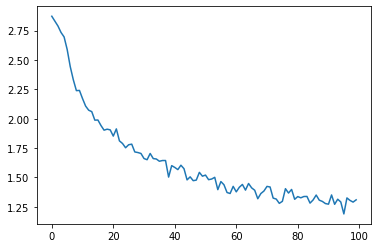

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# 4.결과 평가

네트워크(모델)가 다른 카테고리에서 얼마나 잘 작동하는지 보기 위해 모든 실제 언어(행)가 네트워크에서 어떤 언어로 추측(열)되는지 나타내는 `confusion matrix`를 만듭니다.   
`confusion matrix`를 계산하기 위해 `evaluate()`로 많으 수의 샘플을 네트워크에 실행합니다. (`evaluate()`는 `train()`에서 역전파를 빼면 동일합니다.)

In [38]:
# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

<ipython-input-39-d4ed9d43dc20>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-39-d4ed9d43dc20>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


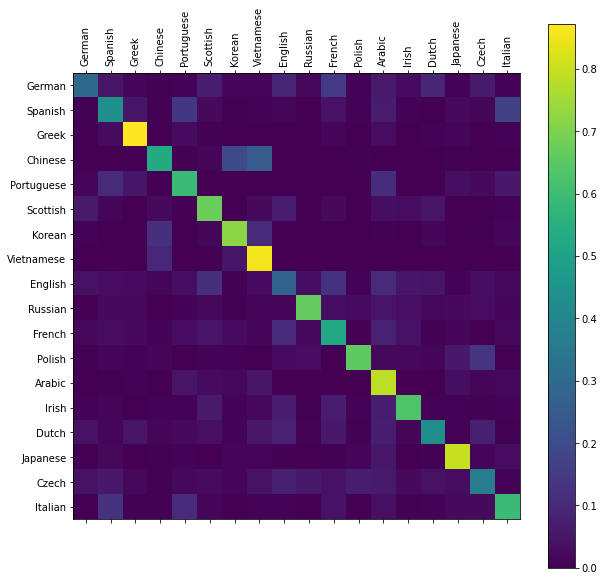

In [39]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 예시 중 어떤 것이 정확히 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## 사용자 입력

In [40]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [41]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.29) Russian
(-1.89) Czech
(-3.03) English

> Jackson
(-1.09) Scottish
(-1.10) English
(-2.04) French

> Satoshi
(-0.74) Arabic
(-1.24) Japanese
(-2.73) Italian
